In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

In [7]:
summary_results = pd.read_csv('../data/results_analysis/summary_results_v2.csv')
summary_results['name'] = summary_results['score'].map({'RAPS':'RAPS',
                                                        'sparsemax':'sparsemax',
                                                        'opt_entmax':'opt-entmax',
                                                        'softmax':'InvProb',      
                                                        'limit':'log-margin',   
                                                        'entmax':'1.5-entmax'
                                                    },na_action="ignore")

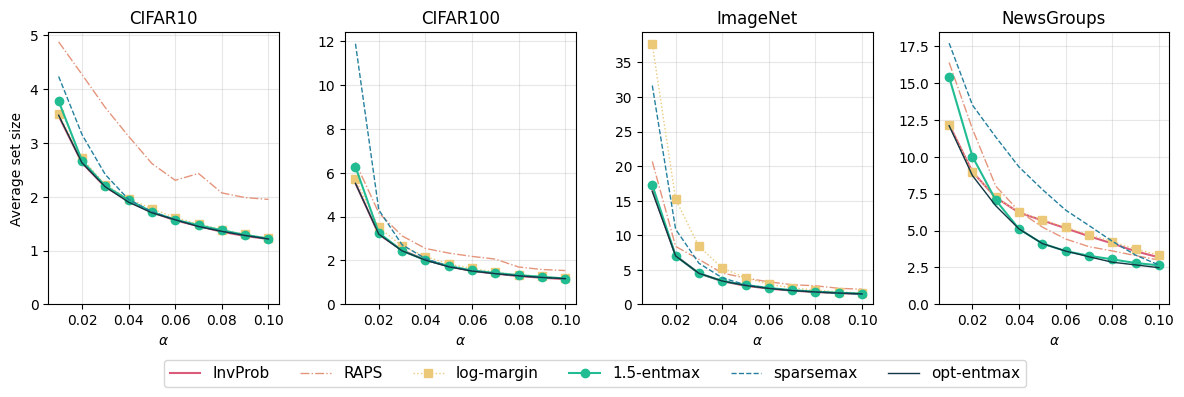

In [8]:
# Example style dictionaries
custom_linestyles = {
    'InvProb': '-',
    'RAPS': '-.',
    'log-margin': ':',
    '1.5-entmax': '-',
    'sparsemax': '--',
    'opt-entmax': '-'
}
custom_markers = {
    'InvProb': None,
    'RAPS': None,
    'log-margin': 's',
    '1.5-entmax': 'o',
    'sparsemax': None,
    'opt-entmax': None
}
custom_linewidths = {
    'InvProb': 1.5,
    'RAPS': 1.0,
    'log-margin': 1,
    '1.5-entmax': 1.5,
    'sparsemax': 1,
    'opt-entmax': 1
}
color_map = {
    'InvProb': '#da5c7a',
    'RAPS': '#e5957c',
    'log-margin': '#ecc979',
    '1.5-entmax': '#22bc93',
    'sparsemax': '#24809e',
    'opt-entmax': '#103743'
}
legend_labels = ['InvProb', 'RAPS', 'log-margin', '1.5-entmax', 'sparsemax', 'opt-entmax']

# --- Make sure summary_results has the columns dataset, name, alpha, avg_size ---
# summary_results = pd.read_csv("my_file.csv")  # or however you're loading your data

# Example figure with 4 subplots (one per dataset)
fig, axs = plt.subplots(1, 4, figsize=(12, 4))
unique_datasets = summary_results['dataset'].unique()

for i, dataset_name in enumerate(unique_datasets):
    ax = axs[i]
    
    # Select rows for this dataset
    df_dataset = summary_results[summary_results['dataset'] == dataset_name]
    
    # Plot each method
    for method_name in legend_labels:
        # Filter just this method
        df_sub = df_dataset[df_dataset['name'] == method_name]
        
        # If multiple rows per alpha (e.g. seeds), average them
        df_agg = df_sub.groupby('alpha', as_index=False)['avg_size'].mean()
        
        # Plot one line
        ax.plot(
            df_agg['alpha'], 
            df_agg['avg_size'],
            color=color_map[method_name],
            linestyle=custom_linestyles[method_name],
            linewidth=custom_linewidths[method_name],
            marker=custom_markers[method_name] or '',
            label=method_name
        )
    
    ax.set_title(dataset_name)
    ax.set_xlabel(r'$\alpha$')
    # Only label the y-axis on the first subplot
    if i == 0:
        ax.set_ylabel('Average set size')
    else:
        ax.set_ylabel('')
    
    ax.set_ylim(bottom=0)
    ax.grid(True, alpha=0.3)

# Build a custom legend using matplotlib.lines.Line2D
legend_handles = []
for method_name in legend_labels:
    lh = mlines.Line2D(
        [], [], 
        color=color_map[method_name],
        linestyle=custom_linestyles[method_name],
        linewidth=custom_linewidths[method_name],
        marker=custom_markers[method_name] or '',
        label=method_name
    )
    legend_handles.append(lh)

fig.legend(
    handles=legend_handles, 
    labels=legend_labels,
    loc='lower center',
    ncol=6,
    bbox_to_anchor=(0.5, 0.0),
    fontsize=11
)

# Adjust layout so legend doesn't overlap subplots
plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.show()


/var/folders/q2/bjm3n1qd6jq1npksrk9n26nw0000gn/T/ipykernel_32394/2232576139.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='')
/var/folders/q2/bjm3n1qd6jq1npksrk9n26nw0000gn/T/ipykernel_32394/2232576139.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='')
/var/folders/q2/bjm3n1qd6jq1npksrk9n26nw0000gn/T/ipykernel_32394/2232576139.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='')


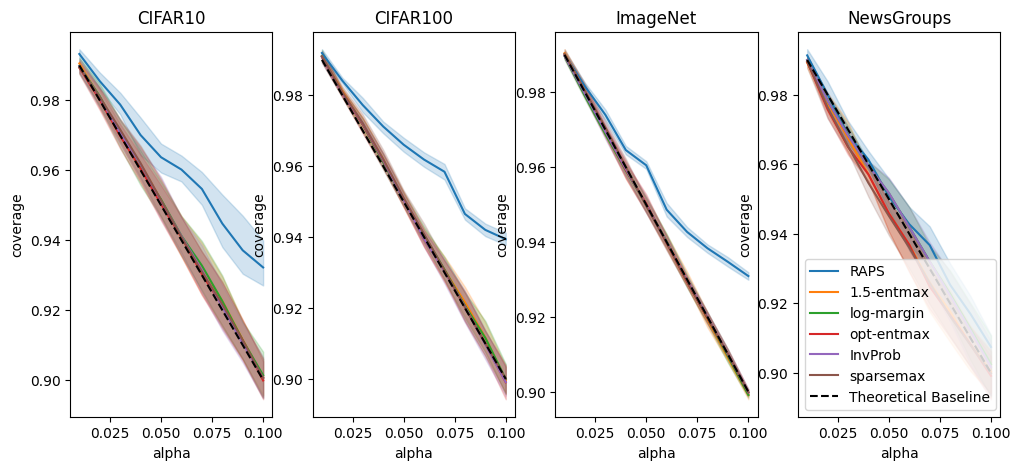

In [9]:
fig, axs = plt.subplots(1,4, figsize=(12,5))
for index, var in enumerate(summary_results['dataset'].unique()):
    df = summary_results[summary_results['dataset']==var]
    if index == len(summary_results['dataset'].unique())-1:
        sns.lineplot(df, hue = 'name',x = 'alpha',y='coverage', ax = axs[index])
    else: 
        sns.lineplot(df, hue = 'name',x = 'alpha',y='coverage', ax = axs[index], legend = False)  
    axs[index].plot([0.01,0.1],[0.99,0.9], label = 'Theoretical Baseline', c='black', linestyle = 'dashed')
  
    axs[index].set_title(var)
    axs[index].set_ylim
    plt.legend(title='')